In [ ]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpBinary
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_players = pd.read_parquet('df_players.parquet')
df_positions = pd.read_parquet('df_positions.parquet')
df_teams = pd.read_parquet('df_teams.parquet')

In [44]:
# Budget
my_budget = 40.0  

# Liste des noms des joueurs à ajouter
selected_names = ["Sánchez", "Dúbravka", "Guéhi", "Senesi", "Van de Ven", "Konsa", "Rodon", "M.Salah", "Reijnders",  
                   "Semenyo", "B.Fernandes", "Caicedo", "", "João Pedro", "Haaland", "Kroupi.Jr"]  # Remplace par les noms souhaités

# Filtrer df_players pour obtenir les joueurs sélectionnés
df_my_team = df_players[df_players["web_name"].isin(selected_names)]

# Afficher l'équipe sélectionnée
df_my_team.sort_values(by = ['position'])

,first_name,web_name,team_short,team_name,position,price,total_points,points_per_cost,ict_index,selected_by_percent,selected_rank,value_form,minutes,transfers_in,transfers_in_event,transfers_out,transfers_out_event,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,defensive_contribution_per_90
id,,,,,,,,,,,,,,,,,,,,,,,,
260,Marc,Guéhi,CRY,Crystal Palace,DEF,47,29.0,0.617021,14.9,21.5,19,1.6,360.0,1278510,240180,261248,14035,0.05,0.00,0.01,0.06,1.00,0.25,6.50
72,Marcos,Senesi,BOU,Bournemouth,DEF,46,28.0,0.608696,16.2,9.1,46,1.9,360.0,999452,140007,116328,22141,0.04,0.00,0.03,0.07,0.87,1.25,13.75
575,Micky,Van de Ven,TOT,Spurs,DEF,46,27.0,0.586957,14.6,30.6,8,1.5,349.0,952781,249627,458715,11350,0.18,0.00,0.01,0.19,1.21,0.26,6.19
348,Joe,Rodon,LEE,Leeds,DEF,40,20.0,0.500000,8.4,3.2,96,1.2,360.0,207687,44238,89294,6777,0.00,0.00,0.00,0.00,1.18,1.50,9.50
38,Ezri,Konsa,AVL,Aston Villa,DEF,45,10.0,0.222222,5.6,12.8,33,0.5,245.0,120391,18249,901604,22430,0.00,0.00,0.02,0.02,2.15,1.10,4.41
249,João Pedro,João Pedro,CHE,Chelsea,FWD,77,33.0,0.428571,33.2,66.7,1,1.3,330.0,2120245,176491,682920,45238,0.41,0.00,0.05,0.46,0.83,0.55,5.18
430,Erling,Haaland,MCI,Man City,FWD,141,37.0,0.262411,45.0,35.6,4,0.6,338.0,1494929,246771,492013,29190,1.51,0.00,0.08,1.59,1.38,1.07,3.99
100,Eli Junior,Kroupi.Jr,BOU,Bournemouth,FWD,45,3.0,0.066667,0.2,1.4,162,0.2,12.0,126021,18350,94619,8663,0.00,0.00,0.00,0.00,1.80,7.50,7.50
220,Robert,Sánchez,CHE,Chelsea,GKP,50,19.0,0.380000,7.9,23.0,15,0.7,360.0,446980,12463,565790,97500,0.00,2.75,0.00,0.00,0.96,0.75,0.00


In [45]:
df_my_team.sum(numeric_only=True)['price'] # Coût total de l'équipe sélectionnée

np.float64(999.0)

In [46]:
# Je possède une équipe de 15 joueurs, je veux savoir si je peux l'améliorer en respectant les contraintes suivantes :
# Mon budget est défini par la valeur my_budget
# Je dois respecter la composition d'équipe suivante : 2 Gardiens (GKP), 5 Défenseurs (DEF), 5 Milieux (MID), 3 Attaquants (FWD)
# Je ne peux pas avoir plus de 3 joueurs par équipe
# Les critères me permattant de déterminer si un joueur va performer : les points_per_cost, l'ict_index, les minutes 

In [47]:
corr = df_players['ict_index'].corr(df_players['total_points'])
print(f"Corrélation entre ict_index et total_points : {corr:.3f}")


Corrélation entre ict_index et total_points : 0.860


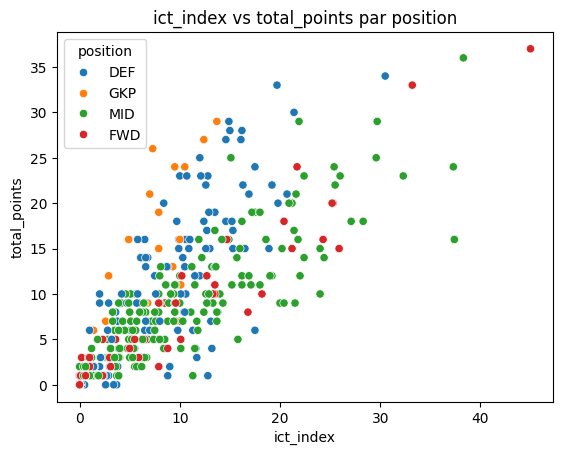

In [54]:
sns.scatterplot(data=df_players, x='ict_index', y='total_points', hue='position')
plt.title('ict_index vs total_points par position')
plt.show()


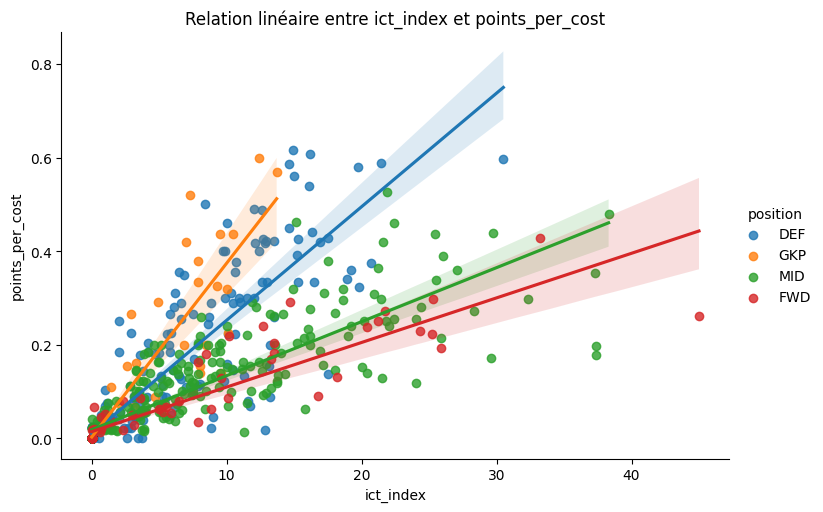

In [56]:
sns.lmplot(data=df_players, x='ict_index', y='points_per_cost', hue='position', aspect=1.5)
plt.title('Relation linéaire entre ict_index et points_per_cost')
plt.show()


In [58]:
import plotly.express as px

fig = px.scatter(
    df_players,
    x='ict_index',
    y='points_per_cost',
    #text='web_name',  # Affiche le nom au survol
    color='position', # Optionnel, couleur par poste
    title='ict_index vs total_points (Hover pour nom du joueur)'
)

fig.update_traces(marker=dict(size=10, opacity=0.7),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.show()
